In [11]:
from scipy.io import loadmat
from matplotlib.pyplot import (
    figure,
    subplot,
    plot,
    xlabel,
    ylabel,
    title,
    yticks,
    show,
    legend,
    imshow,
    cm,
)
import scipy.linalg as linalg
from scipy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import xlrd
import pandas as pd
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

file_path = r"C:\Denmark\School\DTU_1\ML, DM\Report2\Machine-Learning-report2\MAIN_Movies_DS.xls"
doc = xlrd.open_workbook(file_path).sheet_by_index(0)

# Extract attribute names
attributeNames = doc.row_values(0, 2, 10)

# Extract MPAA names to python list, then encode with integers (dict)
mpaa = doc.col_values(3, 2, 636)
mpaa_name = sorted(set(mpaa))  # set because it deletes the duplicates
mpaaDict = dict(zip(mpaa_name, range(5)))

# Extract names to python list, then encode with integers (dict)
# the column Genre was moved to this position in excel
genre = doc.col_values(2, 2, 636)
genre_name = sorted(set(genre))
genreDict = dict(zip(genre_name, range(18)))
print(genreDict)

title = doc.col_values(1, 2, 636)
title_name = sorted(set(title))
titleDict = dict(zip(title_name, range(627)))

rating = doc.col_values(8, 2, 636)
rating_name = sorted(set(rating))
ratDict = dict(zip(rating_name, range(627)))

# Extract vector y, convert to NumPy array
y_mpaa = np.array([mpaaDict[value] for value in mpaa])
y_genre = np.array([genreDict[value] for value in genre])
y_title = np.array([titleDict[value] for value in title])
y_rat = np.array([ratDict[value] for value in rating])

{'Action': 0, 'Adventure': 1, 'Animation': 2, 'Comedy': 3, 'Crime': 4, 'Drama': 5, 'Family': 6, 'Fantasy': 7, 'History': 8, 'Horror': 9, 'Musical': 10, 'Mystery': 11, 'Romance': 12, 'Science Fiction': 13, 'Thriller': 14, 'War': 15, 'Western': 16}


### Main dataframe to use for regression and classification

In [12]:
# Create a dataframe from the data
data = pd.DataFrame(
    {
        "MPAA_Rating": y_mpaa,
        "genre": y_genre,
        "title": y_title,
        "Budget": doc.col_values(4, 2, 636),
        "Gross": doc.col_values(5, 2, 636),
        "release_date": doc.col_values(6, 2, 636),
        "runtime": doc.col_values(7, 2, 636),
        "rating": doc.col_values(8, 2, 636),
        "rating_count": doc.col_values(9, 2, 636),
    }
)

# DATA CLEANING
# Remove duplicates based on the "title" column
data = data.drop_duplicates(subset="title", keep="first")

# Extract X and y from the cleaned dataframe
X = data[
    [
        "MPAA_Rating",
        "genre",
        "Budget",
        "Gross",
        "release_date",
        "runtime",
        "rating",
        "rating_count",
    ]
].values
y_mpaa = data["MPAA_Rating"].values
y_genre = data["genre"].values
y_gross = data["Gross"].values > 4 * data["Budget"].values
y_rat = data["rating"].values > 7

N_mpaa = len(y_mpaa)
N_genre = len(y_genre)
M = len(attributeNames)
C_mpaa = len(mpaa_name)
C_genre = len(genre_name)

df_X = pd.DataFrame(X, columns=[
        "MPAA_Rating",
        "genre",
        "Budget",
        "Gross",
        "release_date",
        "runtime",
        "rating",
        "rating_count",
    ])
print(df_X)

     MPAA_Rating  genre       Budget        Gross  release_date  runtime  \
0            1.0    3.0    7500000.0  145793296.0       32855.0     99.0   
1            1.0    4.0   13000000.0   71079915.0       32717.0    100.0   
2            3.0   15.0   14000000.0  161001698.0       32862.0    145.0   
3            1.0    5.0   15000000.0   84431625.0       32619.0    107.0   
4            1.0    6.0   15000000.0   79258538.0       32736.0    100.0   
..           ...    ...          ...          ...           ...      ...   
621          2.0    0.0  250000000.0  765199095.0       44477.0    163.0   
622          2.0   10.0   55000000.0     106457.0       44512.0    115.0   
623          2.0    0.0  110000000.0  212500000.0       44470.0    157.0   
624          2.0    3.0   17000000.0  115400000.0       41187.0    112.0   
625          2.0    3.0   20000000.0   57200000.0       38793.0    105.0   

     rating  rating_count  
0       7.4       91075.0  
1       7.2       91415.0  
2  

### Preparation of the features matrix and the target label

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# y_mpaa = vector with MPAA ratings of the movies
# y_mpaa_filtered = y_mpaa with only PG e R 
# df_X = features matrix (panda dataframe)
# df_X_filtered = df_X with only movies that are PG or R
# df_X_noMPAA = df_X_filtered without mpaa column
# df_X_noMPAA_std = df_X_noMPAA standardised

# keep in X only the movies that have PG or R rating
y_mpaa = df_X['MPAA_Rating']
df_X_filtered = df_X[(df_X['MPAA_Rating'] != 0) & (df_X['MPAA_Rating'] != 2)]
y_mpaa_filtered = df_X_filtered["MPAA_Rating"]

# remove the mpaa_rating column from X
df_X_noMPAA = df_X_filtered.drop(columns=['MPAA_Rating'])
print(df_X_noMPAA)

# Standardization
scaler = StandardScaler()
scaler.fit(df_X_noMPAA)
df_X_noMPAA_std = scaler.transform(df_X_noMPAA)


     genre       Budget        Gross  release_date  runtime  rating  \
0      3.0    7500000.0  145793296.0       32855.0     99.0     7.4   
1      4.0   13000000.0   71079915.0       32717.0    100.0     7.2   
2     15.0   14000000.0  161001698.0       32862.0    145.0     7.2   
3      5.0   15000000.0   84431625.0       32619.0    107.0     7.5   
4      6.0   15000000.0   79258538.0       32736.0    100.0     7.0   
..     ...          ...          ...           ...      ...     ...   
601    1.0  170000000.0  353000000.0       43535.0    112.0     6.3   
610   12.0   10000000.0   10055355.0       43882.0    124.0     6.7   
611    2.0  150000000.0  121000000.0       44115.0    100.0     8.1   
612    3.0   87000000.0  148970000.0       44064.0     99.0     6.5   
619    6.0  150000000.0  226163416.0       44524.0    109.0     7.3   

     rating_count  
0         91075.0  
1         91415.0  
2         91415.0  
3        101702.0  
4         77659.0  
..            ...  
601    

### Logistic regression with 2 level CV (10 outer folds and 10 inner folds)

best error = 0.25, best lambda = 0.1
error on the outer fold = 0.22580645161290325, with lambda = 0.1


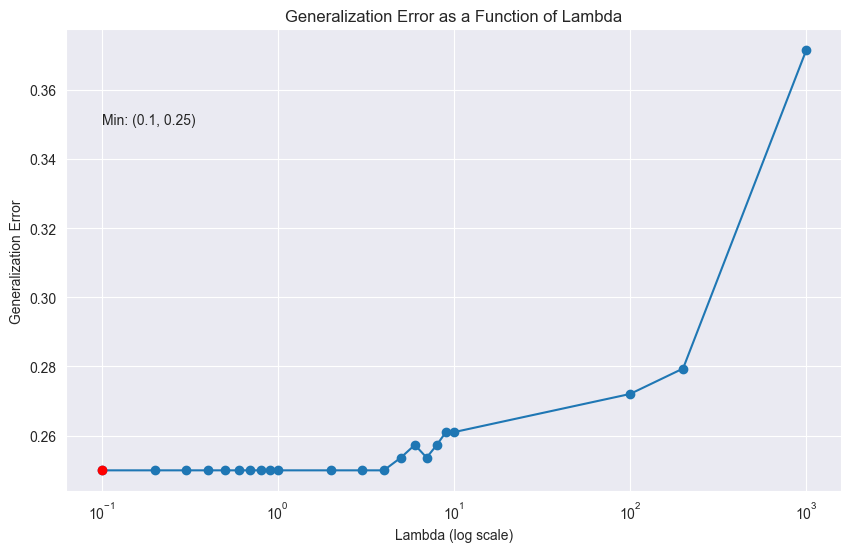

best error = 0.23897058823529413, best lambda = 0.6
error on the outer fold = 0.29032258064516125, with lambda = 0.6


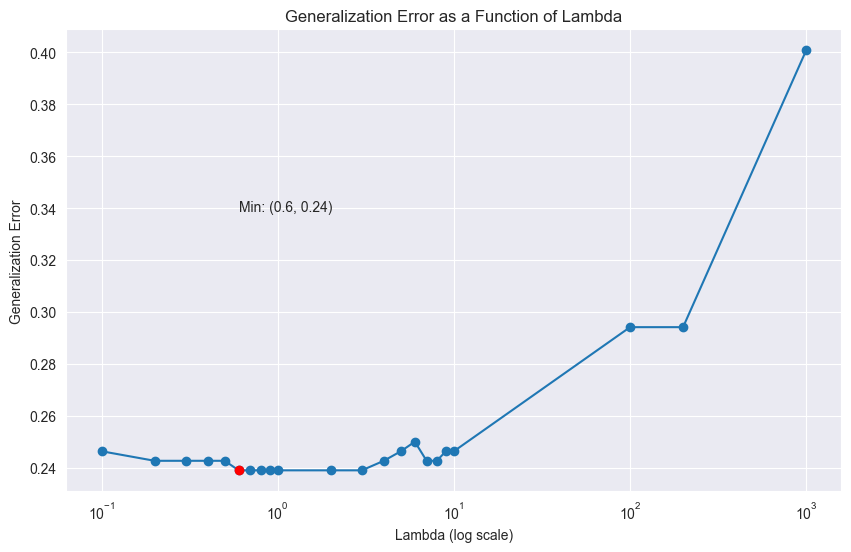

best error = 0.24632352941176472, best lambda = 0.1
error on the outer fold = 0.16129032258064513, with lambda = 0.1


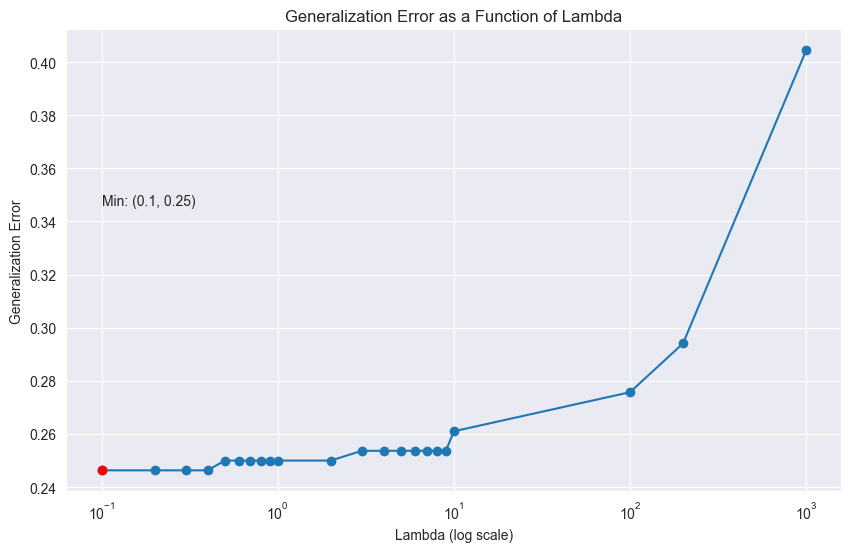

best error = 0.21245421245421245, best lambda = 0.1
error on the outer fold = 0.30000000000000004, with lambda = 0.1


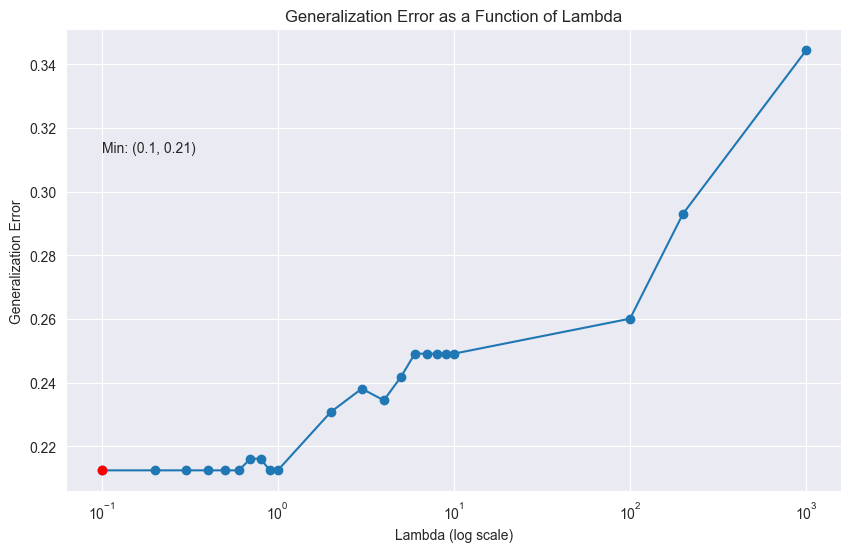

best error = 0.23443223443223443, best lambda = 2
error on the outer fold = 0.16666666666666663, with lambda = 2


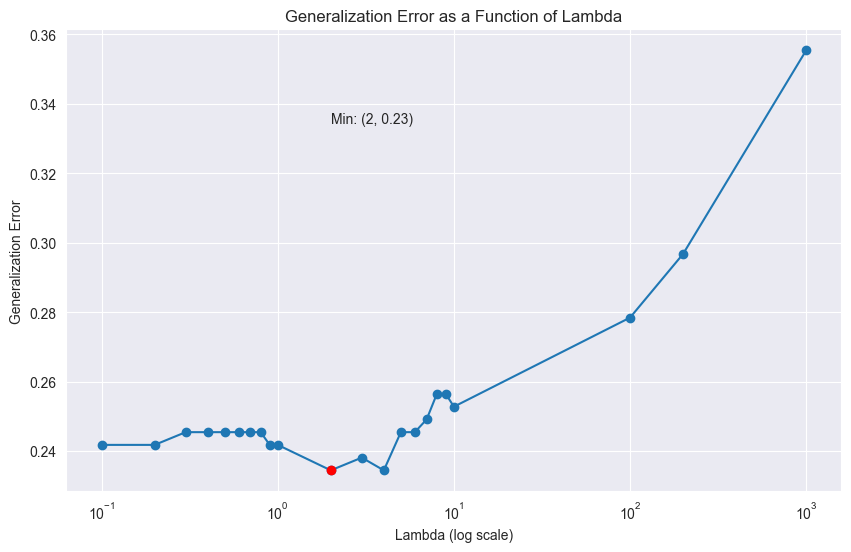

best error = 0.23443223443223443, best lambda = 0.9
error on the outer fold = 0.2666666666666667, with lambda = 0.9


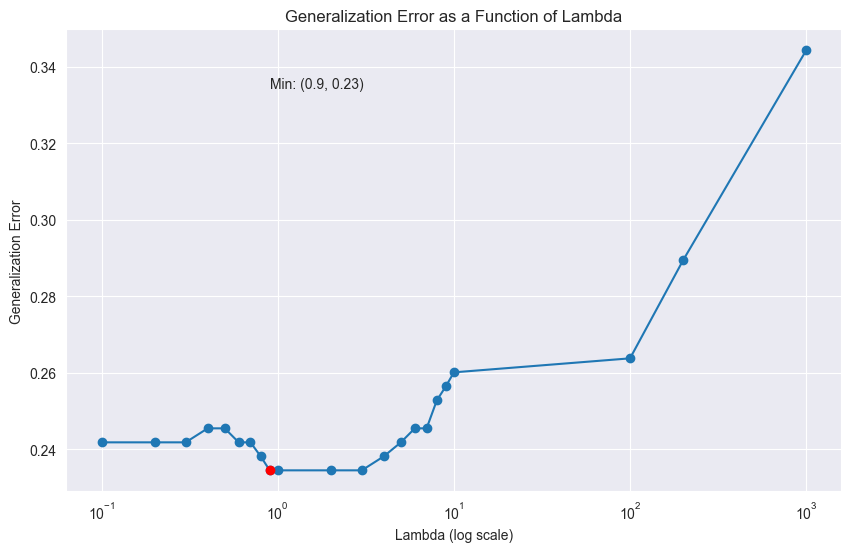

best error = 0.22344322344322345, best lambda = 7
error on the outer fold = 0.2666666666666667, with lambda = 7


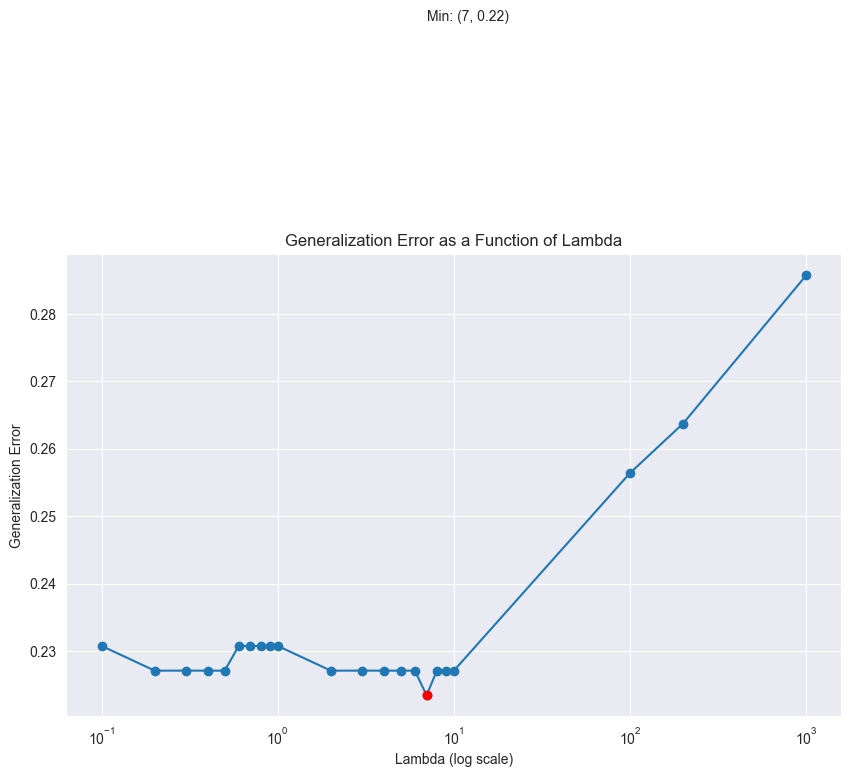

best error = 0.23076923076923078, best lambda = 2
error on the outer fold = 0.23333333333333328, with lambda = 2


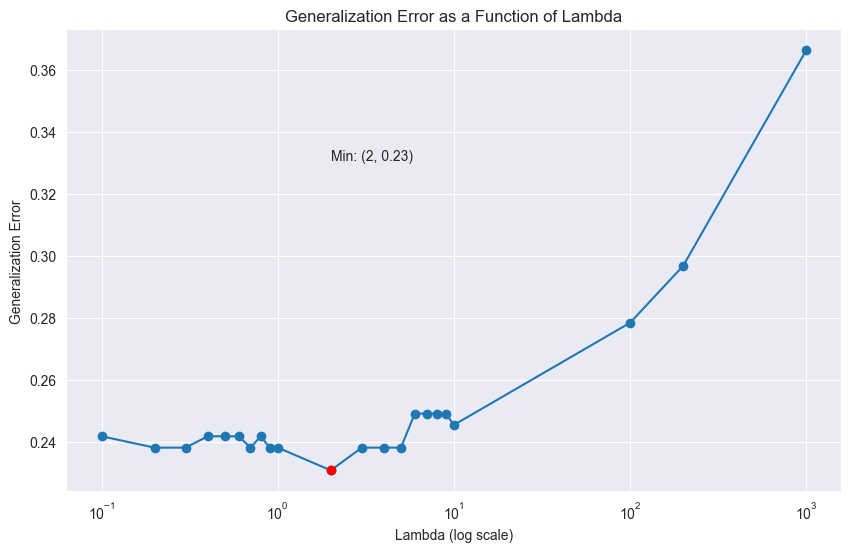

best error = 0.21978021978021978, best lambda = 2
error on the outer fold = 0.30000000000000004, with lambda = 2


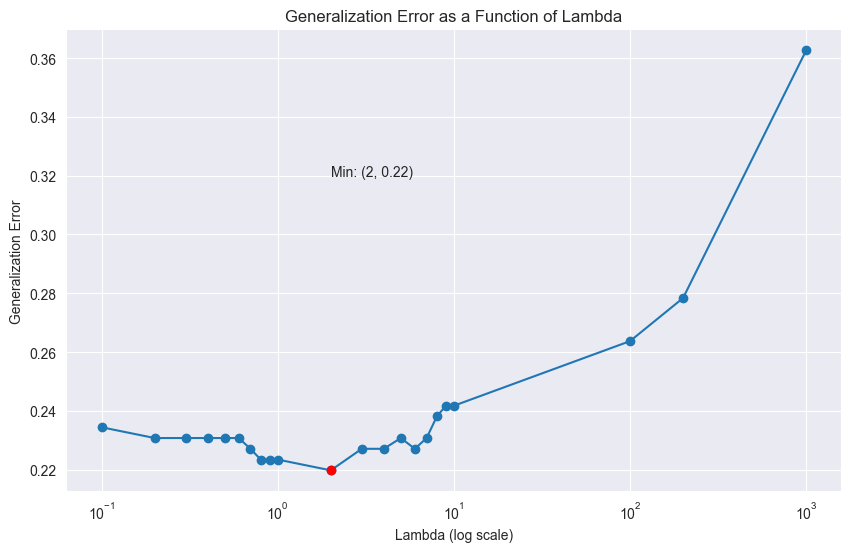

best error = 0.23809523809523808, best lambda = 0.7
error on the outer fold = 0.19999999999999996, with lambda = 0.7


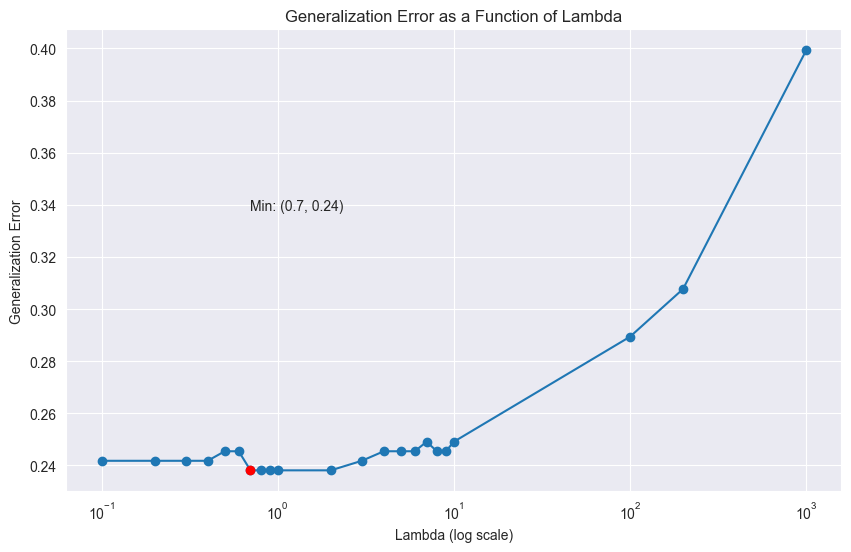

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
import seaborn as sns


# Define the number of folds for outer and inner cross-validation
outer_folds = 10
inner_folds = 10

# Initialize objects for outer cross-validation
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# List to store the scores of outer cross-validation
outer_scores = []

# Perform outer cross-validation
for train_index, test_index in outer_cv.split(df_X_noMPAA_std):
    X_train = df_X_noMPAA_std[train_index]
    X_test = df_X_noMPAA_std[test_index] 
    y_train = y_mpaa_filtered.to_numpy()[train_index]
    y_test = y_mpaa_filtered.to_numpy()[test_index]

    # Define the range of λ values to explore
    lambda_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 200, 1000]
    #lambda_values = np.arange(0.1, 10.01, 0.1, dtype = "float")
    #lambda_values = np.arange(0.02, 10, 0.2, dtype="float")

    #errors contains generalization error for each lambda
    errors = []
    best_error_lambda_i = 1
    best_lambda_i = None

    for lambda_i in lambda_values:
        inner_model = LogisticRegression(C = 1/lambda_i)

        #10 fold cross validation 
        scores = cross_val_score(inner_model, X_train, y_train, cv=10)
        mean_score = scores.mean()

        # Calcola il numero di osservazioni misclassificate
        y_pred = cross_val_predict(inner_model, X_train, y_train, cv=10)  # Previsioni del modello
        cm = confusion_matrix(y_train, y_pred)  # Matrice di confusione
        FP = cm[0][1]  # Falsi positivi
        FN = cm[1][0]  # Falsi negativi

        num_observations = X_train.shape[0]
        gen_err_lambda_i = (FP + FN) / num_observations; #number of misclassified observations
        errors.append(gen_err_lambda_i)
        if gen_err_lambda_i < best_error_lambda_i:
            best_error_lambda_i = gen_err_lambda_i #update the lowest generalization error for the current outer fold
            best_lambda_i = lambda_i #update the best lambda for the current outer fold

    #use best lmabda of the current outer fold to train the model
    final_model = LogisticRegression(C=1/best_lambda_i)  
    final_model.fit(X_train, y_train)

    #test the model with the test data of the current outer fold
    final_predictions = final_model.predict(X_test)

    # Calcola l'errore basato su final_predictions
    accuracy = accuracy_score(y_test, final_predictions)  # Calcola l'accuratezza

    error_outer_fold = 1 - accuracy  # L'errore è la differenza tra 1 e l'accuratezza  



    print(f"best error = {best_error_lambda_i}, best lambda = {best_lambda_i}")
    print(f"error on the outer fold = {error_outer_fold}, with lambda = {best_lambda_i}")
    # Create a plot of generalization error as a function of λ
    sns.set_style('dark')
    plt.figure(figsize=(10, 6))
    plt.semilogx(lambda_values, errors, marker='o', linestyle='-')
    plt.title('Generalization Error as a Function of Lambda')
    plt.xlabel('Lambda (log scale)')
    plt.ylabel('Generalization Error')
    plt.grid(True)
    # Trova il minimo
    min_index = errors.index(min(errors))
    min_lambda = lambda_values[min_index]
    min_error = errors[min_index]

    # Evidenzia il minimo con un cerchio rosso
    plt.scatter(min_lambda, min_error, color='red', zorder=5)
    plt.annotate(f'Min: ({min_lambda}, {min_error:.2f})', xy=(min_lambda, min_error), xytext=(min_lambda, min_error + 0.1))
    plt.show()

    

### Train a logistic regression model using a suitable value of λ and analyze the weights

        Feature  Coefficient
4       runtime     1.431353
6  rating_count     0.721624
3  release_date     0.104989
0         genre     0.058678
5        rating    -0.259646
2         Gross    -0.523328
1        Budget    -0.863373


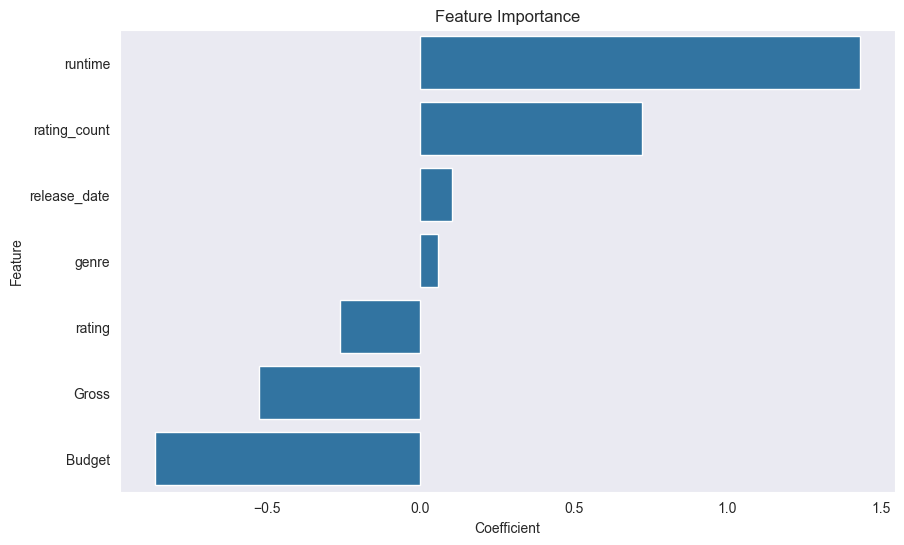

In [15]:

train_dataset = df_X_noMPAA_std
target_label = y_mpaa_filtered
lambda_value = 2

logreg_model = LogisticRegression(C=1/lambda_value) 
logreg_model.fit(X_train, y_train)

# Extract feature coefficients
feature_coefficients = logreg_model.coef_[0]

# Associate coefficients with respective features
feature_names = df_X_noMPAA.columns  # Replace with actual feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_coefficients})

# Sort coefficients by importance
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
print(coefficients_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df, orient='h')
plt.title('Feature Importance')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

### Baseline with 2 level cross validation

In [16]:
import pandas as pd
from sklearn.dummy import DummyClassifier

# y_mpaa = vector with MPAA ratings of the movies
# y_mpaa_filtered = y_mpaa with only PG and R
# df_X = features matrix (Pandas DataFrame)
# df_X_filtered = df_X with only movies that are PG or R
# df_X_noMPAA = df_X_filtered without the MPAA column
# df_X_noMPAA_std = standardized df_X_noMPAA

# Define the number of folds for outer and inner cross-validation
outer_folds = 10
inner_folds = 10

# Initialize objects for outer cross-validation
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# List to store the scores of outer cross-validation
outer_scores = []

#Perform outer cross-validation
for train_index, test_index in outer_cv.split(df_X_noMPAA_std):
    X_train = df_X_noMPAA_std[train_index]
    y_train = y_mpaa_filtered.to_numpy()[train_index]
    # number of MPAA Rating = 1
    num_mpaa_1 = (y_train == 1).sum()

    # number of MPAA rating = 3
    num_mpaa_3 = (y_train == 3).sum()

    # Calculate the most frequent MPAA Rating class in the training data
    most_frequent_mpaa = 1 if num_mpaa_1 > num_mpaa_3 else 3

    # Create a dummy classifier based on the most frequent MPAA Rating class
    baseline_model = DummyClassifier(strategy="constant", constant=int(most_frequent_mpaa))

    # inner 10 fold cross validation 
    y_pred = cross_val_predict(baseline_model, X_train, y_train, cv=10)  # Previsioni del modello
    cm = confusion_matrix(y_train, y_pred)  # Matrice di confusione
    FP = cm[0][1]  # Falsi positivi
    FN = cm[1][0]  # Falsi negativi

    num_observations = X_train.shape[0]
    gen_err_i = (FP + FN) / num_observations; #number of misclassified observations
    errors.append(gen_err_lambda_i)


    print(f"film rated PG (1) = {num_mpaa_1} , film rated R (3) = {num_mpaa_3}, error = {gen_err_i}")



film rated PG (1) = 143 , film rated R (3) = 129, error = 0.4742647058823529
film rated PG (1) = 149 , film rated R (3) = 123, error = 0.4522058823529412
film rated PG (1) = 151 , film rated R (3) = 121, error = 0.44485294117647056
film rated PG (1) = 143 , film rated R (3) = 130, error = 0.47619047619047616
film rated PG (1) = 143 , film rated R (3) = 130, error = 0.47619047619047616
film rated PG (1) = 142 , film rated R (3) = 131, error = 0.47985347985347987
film rated PG (1) = 140 , film rated R (3) = 133, error = 0.48717948717948717
film rated PG (1) = 145 , film rated R (3) = 128, error = 0.46886446886446886
film rated PG (1) = 146 , film rated R (3) = 127, error = 0.4652014652014652
film rated PG (1) = 147 , film rated R (3) = 126, error = 0.46153846153846156


### KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Define the number of folds for outer and inner cross-validation
outer_folds = 10
inner_folds = 10

# Initialize objects for outer cross-validation
outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# List to store the scores of outer cross-validation
outer_scores = []

# Perform outer cross-validation
for train_index, test_index in outer_cv.split(df_X_noMPAA_std):
    X_train = df_X_noMPAA_std[train_index]
    X_test = df_X_noMPAA_std[test_index]
    y_train = y_mpaa_filtered.to_numpy()[train_index]
    y_test = y_mpaa_filtered.to_numpy()[test_index]
    

    # Define the range of k values to explore
    k_values = np.arange(1, 15, 1, dtype = "int")
    #lambda_values = np.arange(0.02, 10, 0.2, dtype="float")

    #errors contains generalization error for each lambda
    errors = []
    best_error_k = 1
    best_k = None

    for k in k_values:
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        #10 fold cross validation 
        scores = cross_val_score(knn_classifier, X_train, y_train, cv=10)
        mean_score = scores.mean()

        # Calcola il numero di osservazioni misclassificate
        y_pred = cross_val_predict(knn_classifier, X_train, y_train, cv=10)  # Previsioni del modello
        cm = confusion_matrix(y_train, y_pred)  # Matrice di confusione
        FP = cm[0][1]  # Falsi positivi
        FN = cm[1][0]  # Falsi negativi

        num_observations = X_train.shape[0]
        gen_err_i = (FP + FN) / num_observations; #number of misclassified observations
        errors.append(gen_err_lambda_i)

        if gen_err_i < best_error_k:
            best_error_k = gen_err_i #update the lowest generalization error
            best_k = k #update the best k for the current outer fold

   
    #use best k of the current outer fold to train the model
    final_model =  KNeighborsClassifier(n_neighbors=best_k)
    final_model.fit(X_train, y_train)

    #test the model with the test data of the current outer fold
    final_predictions = final_model.predict(X_test)

    # compute error based on final_predictions
    accuracy = accuracy_score(y_test, final_predictions)  # accuracy

    error_outer_fold = 1 - accuracy  # L'errore è la differenza tra 1 e l'accuratezza
    print(f"best error = {error_outer_fold}, best k = {best_k}")

best error = 0.25806451612903225, best k = 3
best error = 0.25806451612903225, best k = 8
best error = 0.16129032258064513, best k = 5
best error = 0.2666666666666667, best k = 7
best error = 0.1333333333333333, best k = 5
best error = 0.19999999999999996, best k = 3
best error = 0.23333333333333328, best k = 7
best error = 0.19999999999999996, best k = 5
best error = 0.30000000000000004, best k = 3
best error = 0.1333333333333333, best k = 5


### Statistical Evaluation: Performance

In [34]:
import scipy.stats
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier


# Variables for performance evaluation
y_hat = []
y_true = []

models = []

best_lambda = 2
best_k = 5
# Define the number of folds for outer and inner cross-validation
K = 10

# Initialize objects for outer cross-validation
outer_cv = KFold(n_splits=K, shuffle=True, random_state=42)

# List to store the scores of outer cross-validation
outer_scores = []

# Perform outer cross-validation
for train_index, test_index in outer_cv.split(df_X_noMPAA_std):
    X_train = df_X_noMPAA_std[train_index]
    X_test = df_X_noMPAA_std[test_index]
    y_train = y_mpaa_filtered.to_numpy()[train_index]
    y_test = y_mpaa_filtered.to_numpy()[test_index]
    dy = []

    # Baseline model
    # number of MPAA Rating = 1
    num_mpaa_1 = (y_train == 1).sum()
    # number of MPAA rating = 3
    num_mpaa_3 = (y_train == 3).sum()
    # Calculate the most frequent MPAA Rating class in the training data
    most_frequent_mpaa = 1 if num_mpaa_1 > num_mpaa_3 else 3
    # Create a dummy classifier based on the most frequent MPAA Rating class
    baseline_model = DummyClassifier(strategy="constant", constant=int(most_frequent_mpaa))
    baseline_model.fit(X_train, y_train)
    y_est = baseline_model.predict(X_test)
    dy.append(y_est)

    # Logistic Regression model
    #use best lambda of the current outer fold to train the model
    logreg = LogisticRegression(C=1/best_lambda)
    logreg.fit(X_train, y_train)
    y_est = logreg.predict(X_test)
    dy.append(y_est)


    # KNN model
    knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
    knn_classifier.fit(X_train, y_train)
    y_est = knn_classifier.predict(X_test)
    dy.append(y_est)

    dy = np.stack(dy, axis = 1)
    y_hat.append(dy)
    y_true.append(y_test)

y_hat = np.concatenate(y_hat)
y_true = np.concatenate(y_true)

# Compute accuracy here.
for i in range(3):
    print((y_hat[:,i] == y_true).sum() / y_true.size)
print()

def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    # perform McNemars test
    nn = np.zeros((2,2))
    c1 = yhatA - y_true == 0
    c2 = yhatB - y_true == 0

    nn[0,0] = sum(c1 & c2)
    nn[0,1] = sum(c1 & ~c2)
    nn[1,0] = sum(~c1 & c2)
    nn[1,1] = sum(~c1 & ~c2)

    n = sum(nn.flat);
    n12 = nn[0,1]
    n21 = nn[1,0]

    thetahat = (n12-n21)/n
    Etheta = thetahat

    Q = n**2 * (n+1) * (Etheta+1) * (1-Etheta) / ( (n*(n12+n21) - (n12-n21)**2) )

    p = (Etheta + 1)*0.5 * (Q-1)
    q = (1-Etheta)*0.5 * (Q-1)

    CI = tuple(lm * 2 - 1 for lm in scipy.stats.beta.interval(1-alpha, a=p, b=q) )

    p = 2*scipy.stats.binom.cdf(min([n12,n21]), n=n12+n21, p=0.5)
    print("Result of McNemars test using alpha=", alpha)
    print("Comparison matrix n")
    print(nn)
    if n12+n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=",(n12+n21))

    print("Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = ", CI)
    print("p-value for two-sided test A and B have same accuracy (exact binomial test): p=", p)

    return thetahat, CI, p

# Compute the McNemar, CI and p values
alpha = 0.05

# Baseline - Logistic Regression
print("Baseline - Logistic Regression:")
[thetahat, CI, p] = mcnemar(y_true, y_hat[:,0], y_hat[:,1], alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)
print()

# Baseline - KNN
print("Baseline - KNN:")
[thetahat, CI, p] = mcnemar(y_true, y_hat[:,0], y_hat[:,2], alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)
print()

# Logistic Regression - KNN
print("Logistic Regression - KNN:")
[thetahat, CI, p] = mcnemar(y_true, y_hat[:,1], y_hat[:,2], alpha=alpha)
print("theta = theta_A-theta_B point estimate", thetahat, " CI: ", CI, "p-value", p)

0.5313531353135313
0.7722772277227723
0.8052805280528053

Baseline - Logistic Regression:
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[125.  36.]
 [109.  33.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.31312266255859156, -0.16738309913282345)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 9.906754734264702e-10
theta = theta_A-theta_B point estimate -0.24092409240924093  CI:  (-0.31312266255859156, -0.16738309913282345) p-value 9.906754734264702e-10

Baseline - KNN:
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[127.  34.]
 [117.  25.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (-0.34625647964824624, -0.20003351588050333)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 7.2024588873475634e-12
theta = theta_A-theta_B point estimate -0.2739273927392739  CI:  (-0.34625647964824624, -0.20003351588050333) p-value 7.2024588873475634e-12
